In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Path = "profiles/"
filelist = os.listdir(Path)

In [57]:
def read_all():
    
    flag=0
    flag2=0
    
    user_keys = ['alias', 'username', 'numberPosts', 'descriptionProfile', 'numberFollowers', 'numberFollowing', 'urlProfile', 'urlImgProfile', 'website'] # The keys you want
    post_keys = ['url', 'urlImage', 'numberLikes', 'numberComments', 'localization', 'date', 'description', 'tags', 'multipleImage', 'mentions', 'isVideo', 'filename'] # The keys you want
    
    #user_cols=['urlProfile', 'numberPosts', 'alias', 'descriptionProfile',  'numberFollowers', 'urlImgProfile', 'username', 'website', 'numberFollowing']
    user_cols=['urlProfile', 'alias', 'numberFollowing', 'numberFollowers', 'username', 'numberPosts', 'website', 'descriptionProfile',  'urlImgProfile']
    # might switch multipleImage and isVideo
    post_cols = ['url', 'description',  'date', 'numberLikes', 'tags', 'filename', 'urlImage', 'numberComments', 'localization', 'isVideo', 'multipleImage', 'mentions']
    
    for k in filelist:
        if k.endswith(".json"):  # You could also add "and i.startswith('f')
            
            # Read file
            with open(Path + str(k)) as json_data:
                        data = json.load(json_data)
                            
            if (data['posts']!=[]):
                
                if data["descriptionProfile"]!=None:
                    temp=data["descriptionProfile"]
                    data["descriptionProfile"]=temp[0]
                           
                # Generate user data
                user_data=dict((k, data[k]) for k in user_keys if k in data)
                user_df=pd.DataFrame.from_dict(user_data, orient='index').T

                # Generate posts data for given user
                for i in range(0,len(data['posts'])):
                    
                    for k in post_keys:
                        if k in data['posts'][i]:
                            if isinstance(data['posts'][i][k], str):
                                data['posts'][i][k]=data['posts'][i][k].replace('\r','')

                    post=dict((k, data['posts'][i][k]) for k in post_keys if k in data['posts'][i])

                    if (flag==0):
                        all_posts=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        flag=1
                    else:
                        new_post=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        all_posts=np.vstack((all_posts,new_post)) 


                if (flag2==0):
                    total=pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))
                    flag2=1
                else:
                    total=np.vstack((total,pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))))   
           
                flag=0

    dataset=pd.DataFrame(total, columns=user_cols+post_cols)
    return dataset[["alias", "username", "numberFollowers", "numberFollowing", "numberPosts", 'urlProfile', 'urlImgProfile', 'descriptionProfile', 'website', 'filename', 'url', 'urlImage', 'numberLikes', 'numberComments', 'description', 'tags', 'mentions', 'localization', 'date', 'multipleImage', 'isVideo']]

In [1]:
dataset = read_all()
dataset.to_csv('dataset.csv', index=False)

NameError: name 'read_all' is not defined

# Import Dataset

In [14]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')
y=full["numberLikes"]

toDrop = ['numberLikes', 'numberComments', 'username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

### Convert website to categorical features

In [15]:
#pd.DataFrame(processed.website.unique()).to_csv('website.csv', index=False)

In [16]:
processed['youtube']=processed['website'].str.contains("youtube|youtu", na=False).astype(int)
processed['music']=processed['website'].str.contains("soundcloud|spoti", na=False).astype(int)
processed['tumblr']=processed['website'].str.contains("tumblr", na=False).astype(int)
processed['facebook']=processed['website'].str.contains("facebook", na=False).astype(int)
processed['blog']=processed['website'].str.contains("blog|wordpress", na=False).astype(int)
processed['twitter']=processed['website'].str.contains("twitter", na=False).astype(int)
processed['other']=processed['website'].str.contains(".", na=False).astype(int)

processed = processed.drop(['website'], axis=1)

### Convert multipleImage to int

In [17]:
processed['multipleImage']=processed['multipleImage'].astype(int)

### Convert dates to days of week

In [18]:
copy=processed["date"].copy()
for i in range(0, 20740):
    copy[i] = datetime.weekday((dateutil.parser.parse(processed["date"][i])))
processed["date"]=copy.astype(np.int64)

In [19]:
processed['mon']=(processed['date']==0).astype(int)
processed['tue']=(processed['date']==1).astype(int)
processed['wed']=(processed['date']==2).astype(int)
processed['thu']=(processed['date']==3).astype(int)
processed['fri']=(processed['date']==4).astype(int)
processed['sat']=(processed['date']==5).astype(int)
processed['sun']=(processed['date']==6).astype(int)

processed = processed.drop(['date'], axis=1)

### Alias processing

In [21]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["alias"]=alias_num

In [77]:
processed

,alias,numberFollowers,numberFollowing,numberPosts,multipleImage,youtube,music,tumblr,facebook,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun,likes
0,2055,359000,127,2745,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,116000
1,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,114000
2,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,117000
3,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,105000
4,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,117000
5,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,109000
6,2055,359000,127,2745,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,10015
7,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,115000
8,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,12054
9,2055,359000,127,2745,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,108000


In [99]:
processed["likes"]=y

avgLikes = []
numFollowers = []

for i in range(0,10):
    np.append(numFollowers, processed[processed["alias"]==i]['numberFollowers'].iloc[0])
    np.append(avgLikes, np.sum(processed[processed["alias"]==i]["likes"])/len(processed[processed["alias"]==i]))

#num=processed[processed["alias"]==2]
#np.sum(processed[processed["alias"]==1]["likes"])/len(processed[processed["alias"]==1])
    

In [101]:
numFollowers

[]

4726.8000000000002

10

In [58]:
numLikes

206000

In [11]:
# One hot encoding
encoder = OneHotEncoder()
encoder.fit(processed["alias"].values.reshape(-1, 1))
alias_sparse = encoder.transform(processed["alias"].values.reshape(-1, 1))

In [12]:
#processed = processed.drop(['alias'], axis=1)

In [28]:
alias_sparse.shape

(20740, 2081)

In [26]:
X_user=sp.sparse.hstack((processed.astype(float), alias_sparse))

In [60]:
lol = processed.sort_values(['numberFollowers'], ascending=[False])


In [20]:
processed

,alias,numberFollowers,numberFollowing,numberPosts,multipleImage,youtube,music,tumblr,facebook,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun
0,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
6,yarasantosoficial,359000,127,2745,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
7,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
8,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9,yarasantosoficial,359000,127,2745,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
sns.pairplot(processed)

# Create train and test dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_user, y, test_size=0.2, random_state=0)

In [30]:
#X_train_user=X_train[["numberFollowers", "numberFollowing", "numberPosts", "date", "multipleImage"]]
#X_test_user=X_test[["numberFollowers", "numberFollowing", "numberPosts", "date", "multipleImage"]]

model_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.48, n_estimators=361)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

69461.3314692


In [ ]:
#X_train_user=X_train[["numberFollowers", "numberFollowing", "numberPosts", "date", "multipleImage"]]
#X_test_user=X_test[["numberFollowers", "numberFollowing", "numberPosts", "date", "multipleImage"]]

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_user, y_train)
y_pred = model_xgb.predict(X_test_user)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

In [54]:
best2=100000
count=0
optimize()

1
{'subsample': 0.8500000000000001, 'learning_rate': 0.1, 'gamma': 0.6000000000000001, 'max_depth': 3, 'colsample_bytree': 0.75}
501
	Score 79401.79649576946


2
{'subsample': 0.6000000000000001, 'learning_rate': 0.45, 'gamma': 0.75, 'max_depth': 3, 'colsample_bytree': 0.9500000000000001}
897
	Score 76045.59570158801


3
4
5
6
{'subsample': 0.7000000000000001, 'learning_rate': 0.35000000000000003, 'gamma': 0.65, 'max_depth': 5, 'colsample_bytree': 0.8}
173
	Score 73531.79726664793


7
8
9
10
11
12
13
14
{'subsample': 0.8500000000000001, 'learning_rate': 0.2, 'gamma': 0.75, 'max_depth': 4, 'colsample_bytree': 0.9500000000000001}
821
	Score 72421.51688498737


15
16
17


KeyboardInterrupt: 

# Data analysis

### Dataset

In [4]:
print('Number of posts: ' + str(len(full)))
print('Number of users: ' + str((full.ix[:,0]).nunique()))

Number of posts: 20740
Number of users: 2081


In [5]:
pd.options.display.float_format = '{:.2f}'.format
full.describe()

,numberFollowers,numberFollowing,numberPosts,numberLikes,numberComments
count,20740.00,20740.00,20740.00,20740.00,20740.00
mean,660326.34,1573.90,1789.22,48826.95,817.68
std,1275151.30,40566.92,2142.68,126016.14,17006.26
min,18.00,0.00,3.00,0.00,0.00
25%,184000.00,231.00,601.00,957.00,13.00
50%,390000.00,431.00,1159.00,2384.00,35.00
75%,694000.00,711.00,2164.00,7263.00,86.00
max,19500000.00,1841877.00,27639.00,1101017.00,872000.00


### Missing values

In [6]:
pd.isnull(full).sum()

alias                     0
username                190
numberFollowers           0
numberFollowing           0
numberPosts               0
urlProfile                0
urlImgProfile             0
descriptionProfile      450
website                3078
filename                  0
url                       0
urlImage                  0
numberLikes               0
numberComments            0
description             322
tags                      0
mentions                  0
localization          10599
date                      0
multipleImage             0
isVideo                   0
dtype: int64

For user: missing website (3078/20740) and descriptionProfile (450/20740)

For posts: missing description (322/20740) posts and localization about half of them

### Visualization

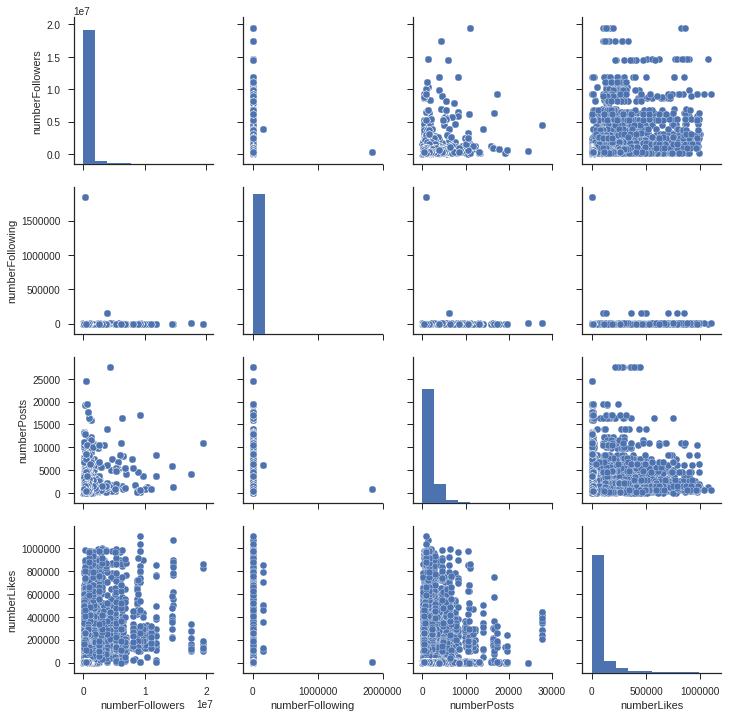

In [108]:
user=full[["numberFollowers", "numberFollowing", "numberPosts", 'numberLikes']]
sns.pairplot(user)

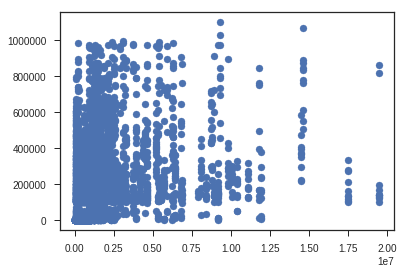

In [109]:
plt.scatter(user['numberFollowers'],user['numberLikes'])

# XGB

In [28]:
X_train_user=X_train[["numberFollowers", "numberFollowing", "numberPosts"]]
X_test_user=X_test[["numberFollowers", "numberFollowing", "numberPosts"]]

In [29]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_user, y_train)
y_pred = model_xgb.predict(X_test_user)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

89249.9655359


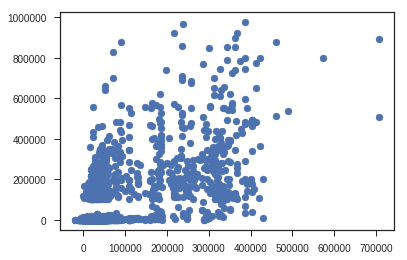

In [111]:
plt.scatter(y_pred, y_test)

In [25]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [28]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
             'max_depth' : hp.choice('max_depth', np.arange(3, 7, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            #'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
            # 'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            #'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              #'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             #'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [29]:
best2=100000
count=0
optimize()

1
{'learning_rate': 0.29, 'max_depth': 5}
540
	Score 72321.99960475974


2
3
{'learning_rate': 0.48, 'max_depth': 3}
361
	Score 69057.80953221086


4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [19]:
train=full.ix[:, full.columns != 'numberLikes']
y=full["numberLikes"]

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=0)

In [12]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train_user, label=y_train)
    dvalid = xgb.DMatrix(X_test_user, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [13]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.05, 0.5, 0.05),
             'max_depth' : hp.choice('max_depth', np.arange(3, 7, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
             'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              #'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             #'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [14]:
best2=100000
count=0
optimize()

1


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields date